In [1]:
import torch
import data
import tqdm
import models
import numpy as np
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
EPOCHS = 1
BATCH_SIZE = 10

In [3]:
dataset = data.LensingDataset('../dataset_1/','vanilla')
dataloader = torch.utils.data.DataLoader(dataset,shuffle=False,batch_size=BATCH_SIZE,num_workers=15)

small_dataset = data.LensingDataset('../dataset_2/','sparse')
small_dataloader = torch.utils.data.DataLoader(small_dataset,shuffle=False,batch_size=BATCH_SIZE,num_workers=15)

In [4]:
model = models.Resnet_SISR(residual_depth=10, 
                           in_channels=1, 
                           maginfication=2, 
                           num_magnifications=1, 
                           latent_channel_count=64).to(device)
model.load_state_dict(torch.load('../trained_weights/ResnetSISR_sparse_DA.pt'))

<All keys matched successfully>

In [5]:
history = {'val_loss':[], 'val_loss2':[]}
loss_fn = torch.nn.MSELoss()
for epoch in range(EPOCHS):
    model.eval()
    for i,(x,y) in enumerate(tqdm.tqdm(small_dataloader, desc=f"Validation epoch {epoch}")):
        (x, y) = (x.float().to(device), y.to(device))
        x = model(x)
        val_loss = loss_fn(x,y)
        history['val_loss'].append(float(val_loss))
    print(f"Validation: {np.mean(history['val_loss'])}")

Validation epoch 0: 100%|██████████| 30/30 [00:04<00:00,  6.66it/s]

Validation: 0.001225309498840943


In [6]:
model.load_state_dict(torch.load('ResnetSISR.pt'))
loss_fn = torch.nn.MSELoss()
for epoch in range(EPOCHS):
    model.eval()
    for i,(x,y) in enumerate(tqdm.tqdm(dataloader, desc=f"Validation epoch {epoch}")):
        (x, y) = (x.float().to(device), y.to(device))
        x = model(x)
        val_loss = loss_fn(x,y)
        history['val_loss2'].append(float(val_loss))
    print(f"Validation: {np.mean(history['val_loss2'])}")

Validation epoch 0: 100%|██████████| 100/100 [00:06<00:00, 15.43it/s]

Validation: 8.077028336385239e-05


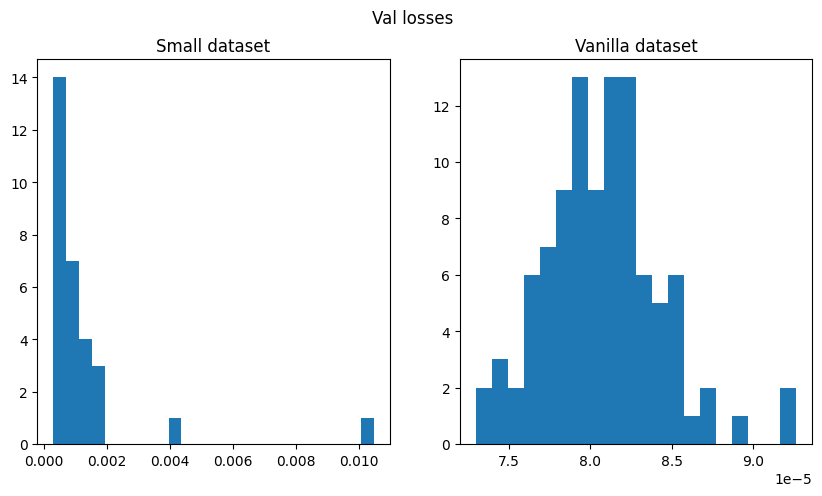

In [14]:
plot, axes = plt.subplots(1,2)
plot.set_size_inches(10,5)
axes[0].hist(np.array(history['val_loss']),bins=25)
axes[1].hist(np.array(history['val_loss2']),bins=20)
axes[0].set_title('Small dataset')
axes[1].set_title('Vanilla dataset')
plot.suptitle('Val losses')
print("")

In [16]:
sorted_val_losses = sorted([(history['val_loss'][i],i) for i in range(len(history['val_loss']))],reverse=True)
outliers1, outliers2 = [], []
for i in sorted_val_losses:
    if i[0] < 0.003: break
    if i[0] > 0.008: outliers1.append(i)
    elif i[0] > 0.003: outliers2.append(i)
print("Very distant outliers %d in number, and less distant ones, %d"%(len(outliers1),len(outliers2)))
print("Distant outliers",outliers1)
print("Less distant outliers",outliers2)

Very distant outliers 1 in number, and less distant ones, 1
Distant outliers [(0.010469666682183743, 1)]
Less distant outliers [(0.00396735779941082, 19)]


/tmp/ipykernel_453972/701682129.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t1 = torch.tensor(LR.view(1,1,image_shape,image_shape))


Text(0.5, 1.0, 'Near_Ground truth')

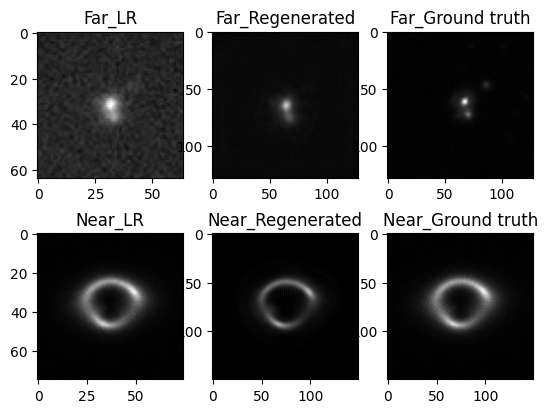

In [23]:
from PIL import Image

def show_random_image(dataset, model, i, image_shape):
    LR, trueHR = dataset[i]
    t1 = torch.tensor(LR.view(1,1,image_shape,image_shape))
    t2 = model(t1.float().to(device)).cpu().detach()
    image1 = Image.fromarray(t1.numpy()[0][0]*255)
    image2 = Image.fromarray(t2.numpy()[0][0]*255)
    image3 = Image.fromarray(trueHR.numpy()[0]*255)
    return image1, image2, image3

model.load_state_dict(torch.load('ResnetSISR_sparse_DA.pt'))
pre, post, tHR = show_random_image(small_dataset, model, outliers1[0][1], 64)
plot, axes = plt.subplots(2,3)
axes[0][0].imshow(pre)
axes[0][1].imshow(post)
axes[0][2].imshow(tHR)
axes[0][0].set_title("Far_LR")
axes[0][1].set_title("Far_Regenerated")
axes[0][2].set_title("Far_Ground truth")

pret, postt, tHRt = show_random_image(dataset, model, outliers2[0][1], 75)
model.load_state_dict(torch.load('ResnetSISR.pt'))
axes[1][0].imshow(pret)
axes[1][1].imshow(postt)
axes[1][2].imshow(tHRt)
axes[1][0].set_title("Near_LR")
axes[1][1].set_title("Near_Regenerated")
axes[1][2].set_title("Near_Ground truth")